In [48]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import time
import random

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, AveragePooling2D, Activation

from keras import Sequential

from syngular.layers.TensorDense import TensorDense

import matplotlib.pyplot as plt

In [49]:
seed_value = 13112022

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [50]:
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.scores import CategoricalScore


In [51]:
from functools import reduce

import tensorflow as tf
from tensorflow.keras.layers import Layer

import numpy as np

from opt_einsum import contract

def unfold_dim(shape):
    return reduce(lambda x, y: x*y, shape)

class TensorDense(Layer):

    def __init__(self, tt_input_shape, tt_output_shape, tt_bond_shape, activation=tf.nn.relu, **kwargs):
        super(TensorDense, self).__init__()

        self.tt_input_shape = tt_input_shape
        self.tt_output_shape = tt_output_shape
        self.tt_bond_shape = tt_bond_shape

        self.tt_input_shape_unfold = unfold_dim(self.tt_input_shape) if self.tt_input_shape != None else None
        self.tt_output_shape_unfold = unfold_dim(self.tt_output_shape)

        if (self.tt_input_shape != None and (len(self.tt_input_shape) != len(self.tt_output_shape) or len(self.tt_input_shape) != len(self.tt_bond_shape)+1)) or len(self.tt_output_shape) != len(self.tt_bond_shape)+1:
            raise Exception(f"Incompatible shapes. Cannot create TensorDense with {len(self.tt_input_shape)} {len(self.tt_output_shape)} and {len(self.tt_bond_shape)} ")

        self.cores = []
        self.cores_number = len(self.tt_input_shape) if self.tt_input_shape != None else len(self.tt_output_shape)

        self.activation = activation

    def build(self, tt_input_shape):

        if self.tt_input_shape == None:
            
            roots = int(np.power(tt_input_shape[1:], 1/self.cores_number))

            self.tt_input_shape = tuple([roots] * self.cores_number)

        self.bias = tf.Variable(tf.zeros(shape=self.tt_output_shape), name="bias", trainable=True)
        
        last_idx = self.cores_number-1        
        
        # Creating the first core of the weight MPS
        self.cores.append(self.add_weight(
            shape = (self.tt_input_shape[0], self.tt_output_shape[0], self.tt_bond_shape[0]),
            name = "core1",
            initializer = "random_normal",
            trainable = True
        ))

        # Creating the intermediate cores of the weight MPS
        for idx in range(1, self.cores_number-1):
            self.cores.append(self.add_weight(
                shape = (self.tt_input_shape[idx], self.tt_output_shape[idx], self.tt_bond_shape[idx-1], self.tt_bond_shape[idx]),
                name = f"core{idx}",
                initializer="random_normal",
                trainable=True
            ))

        # Creating the last core of the weight MPS
        self.cores.append(self.add_weight(
            shape = (self.tt_input_shape[last_idx], self.tt_output_shape[last_idx], self.tt_bond_shape[last_idx-1]),
            name = f"core{self.cores_number}",
            initializer = "random_normal",
            trainable = True
        ))

    def call(self, inputs):

        def process(input, bias):

            x = tf.reshape(input,self.tt_input_shape)

            struct = []
            struct += [x, list(range(1, self.cores_number+1))]
            struct += [self.cores[0], [1, self.cores_number+1, 2*self.cores_number+1]]
            
            for idx in range(2, self.cores_number):
                struct += [self.cores[idx-1]]
                struct += [[idx, self.cores_number+idx, 2*self.cores_number+1, 2*self.cores_number+2]]

            struct += [self.cores[-1], [self.cores_number, 2*self.cores_number, 3*self.cores_number-1]]
            struct += [list(range(self.cores_number+1, 2*self.cores_number+1))]


            result = contract(*struct)

            return result+self.bias

        result = tf.vectorized_map(lambda vec: process(vec, self.bias), inputs)
        return self.activation(tf.reshape(result, (-1, self.tt_output_shape_unfold)))

    def get_config(self):
        config = super().get_config()
        config.update({
            'tt_input_shape': self.tt_input_shape,
            'tt_output_shape': self.tt_output_shape,
            'tt_bond_shape': self.tt_bond_shape,
            'activation': self.activation
        })
        return config

In [52]:
batch_size = 512

In [53]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [54]:
def normalize_img(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return tf.cast(image, tf.float32) / 255., label

In [55]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [56]:
def cifar_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())

    model.add(TensorDense((16,16,8),(24,24,24),(16,16,))) # (4,8,4)
    model.add(BatchNormalization())
    model.add(TensorDense((24,24,24),(8,8,8),(16,16,))) # (4,8,4)
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

model_tn = cifar_model()

model_tn.summary()

model_tn.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [57]:
history_tn = model_tn.fit(
    ds_train,
    epochs=50,
    validation_data=ds_test
)

Epoch 1/50


C:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
C:\Users\Antoine\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/tensor_dense_21/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/tensor_dense_21/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 13824), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/tensor_dense_21/loop_body/GatherV2/pfor/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of m

98/98 [==============================] - 76s 730ms/step - loss: 2.2956 - acc: 0.2963 - val_loss: 2.2971 - val_acc: 0.1000
Epoch 2/50
98/98 [==============================] - 35s 346ms/step - loss: 1.5965 - acc: 0.4410 - val_loss: 2.2465 - val_acc: 0.1063
Epoch 3/50
98/98 [==============================] - 8s 83ms/step - loss: 1.3468 - acc: 0.5186 - val_loss: 1.9950 - val_acc: 0.2690
Epoch 4/50
98/98 [==============================] - 8s 83ms/step - loss: 1.1925 - acc: 0.5772 - val_loss: 1.4693 - val_acc: 0.4947
Epoch 5/50
98/98 [==============================] - 9s 87ms/step - loss: 1.0953 - acc: 0.6094 - val_loss: 1.1117 - val_acc: 0.6111
Epoch 6/50
98/98 [==============================] - 20s 203ms/step - loss: 1.0193 - acc: 0.6387 - val_loss: 0.9222 - val_acc: 0.6704
Epoch 7/50
98/98 [==============================] - 20s 206ms/step - loss: 0.9519 - acc: 0.6625 - val_loss: 0.8818 - val_acc: 0.6866
Epoch 8/50
98/98 [==============================] - 9s 94ms/step - loss: 0.8919 - acc:

In [60]:
images = list(ds_train)

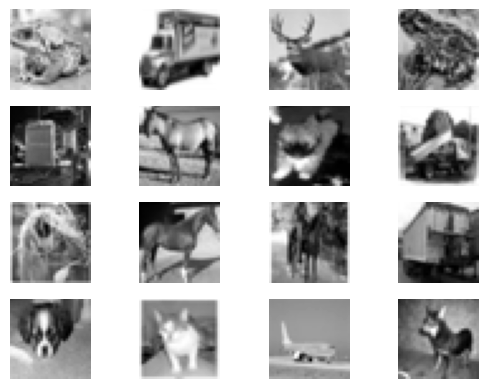

In [94]:
batch_imgs = images[0][0][64:64+16]
batch_labels = list(images[0][1][64:64+16].numpy())

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(batch_imgs[i].numpy().reshape(32,32), cmap='gray')
    # plt.gca().set_title(batch_labels[i])
    plt.axis('off')

In [95]:
replace2linear = ReplaceToLinear()

In [96]:
score = CategoricalScore(batch_labels)
activation_maximization = ActivationMaximization(model_tn, model_modifier=replace2linear, clone=True)

In [97]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model_tn, model_modifier=replace2linear, clone=True)
cam = gradcam(score, batch_imgs, penultimate_layer=-1)

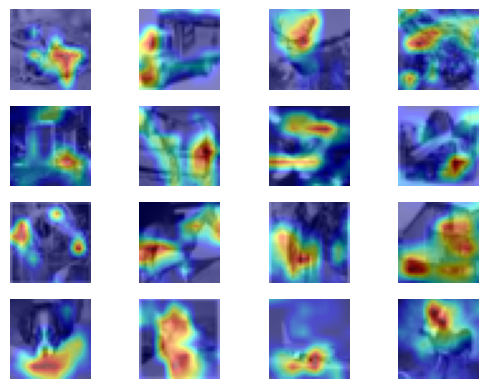

In [98]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(batch_imgs[i].numpy().reshape(32,32), cmap='gray')
    plt.imshow(cam[i], cmap='jet', alpha=0.5)
    plt.axis('off')

In [99]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model_tn, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, batch_imgs, smooth_samples=20, smooth_noise=0.20)


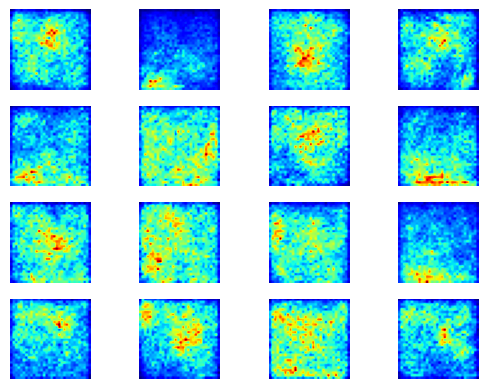

In [100]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    # plt.imshow(batch_imgs[i].numpy().reshape(32,32), cmap='gray')
    plt.imshow(saliency_map[i], cmap='jet')
    plt.axis('off')

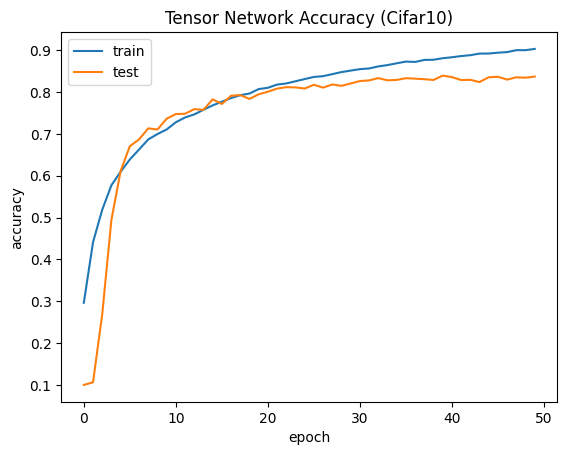

In [84]:
plt.plot(history_tn.history['acc'])
plt.plot(history_tn.history['val_acc'])
plt.title('Tensor Network Accuracy (Cifar10)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

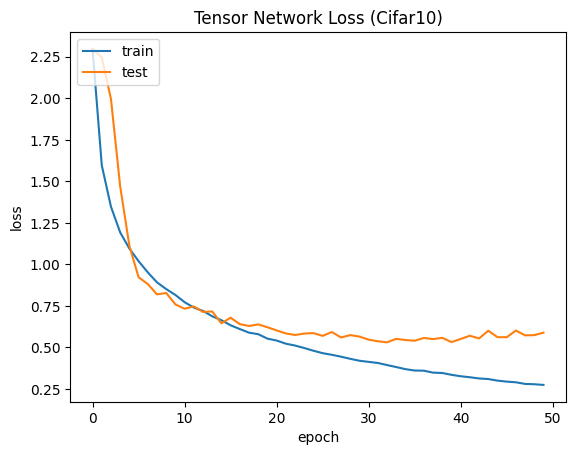

In [87]:
plt.plot(history_tn.history['loss'])
plt.plot(history_tn.history['val_loss'])
plt.title('Tensor Network Loss (Cifar10)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
frogs = []
i = 0

while len(frogs) < 16:
    if images[0][1][i] == 6:
        frogs.append(images[0][0][i])
    i += 1
frogs = np.array(frogs)

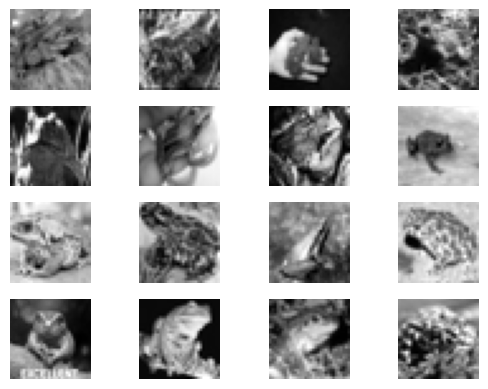

In [102]:

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(frogs[i].reshape(32,32), cmap='gray')
    plt.axis('off')

In [103]:
score = CategoricalScore([6] * 16)
activation_maximization = ActivationMaximization(model_tn, model_modifier=replace2linear, clone=True)

In [104]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus

# gradcam = Gradcam(model_nn, model_modifier=replace2linear, clone=True)
# cam = gradcam(score, frogs, penultimate_layer=-1)
gradcam = GradcamPlusPlus(model_tn, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score, frogs, penultimate_layer=-1)


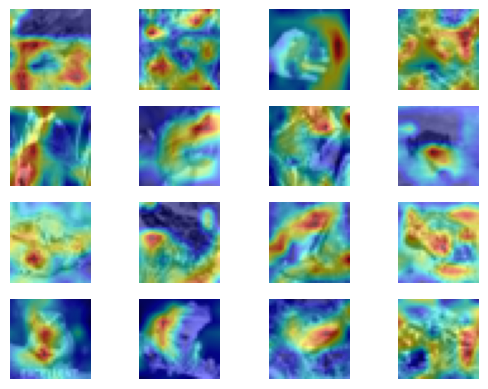

In [105]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(frogs[i].reshape(32,32), cmap='gray')
    plt.imshow(cam[i], cmap='jet', alpha=0.5)
    plt.axis('off')

In [106]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model_tn, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, frogs, smooth_samples=20, smooth_noise=0.20)


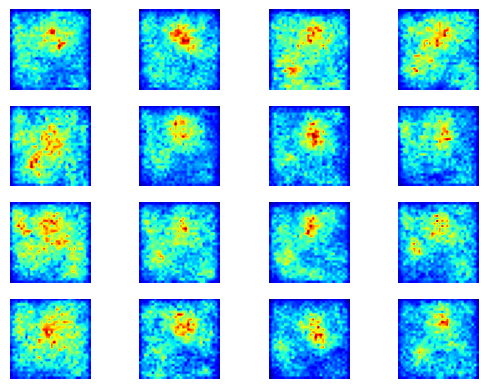

In [107]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(saliency_map[i], cmap='jet')
    plt.axis('off')